In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense,
    Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [ ]:
train_dir = '../data/train'
test_dir = '../data/test'

CLASS_NAMES = ["angry", "fear", "happy", "neutral", "sad", "surprise"]
NUM_CLASSES = len(CLASS_NAMES)

img_height, img_width = 48, 48
batch_size = 32


In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,       
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,         
    zoom_range=0.2,          
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    classes=CLASS_NAMES
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=CLASS_NAMES
)


Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [ ]:
model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
884/884 [==============================] - 17s 18ms/step - loss: 1.9785 - accuracy: 0.2163 - val_loss: 1.7270 - val_accuracy: 0.2677 - lr: 0.0010
Epoch 2/50
884/884 [==============================] - 16s 18ms/step - loss: 1.7508 - accuracy: 0.2593 - val_loss: 1.6551 - val_accuracy: 0.3151 - lr: 0.0010
Epoch 3/50
884/884 [==============================] - 15s 17ms/step - loss: 1.6579 - accuracy: 0.3137 - val_loss: 1.4846 - val_accuracy: 0.4172 - lr: 0.0010
Epoch 4/50
884/884 [==============================] - 15s 17ms/step - loss: 1.5653 - accuracy: 0.3675 - val_loss: 1.4292 - val_accuracy: 0.4353 - lr: 0.0010
Epoch 5/50
884/884 [==============================] - 16s 18ms/step - loss: 1.4818 - accuracy: 0.4070 - val_loss: 1.3791 - val_accuracy: 0.4566 - lr: 0.0010
Epoch 6/50
884/884 [==============================] - 15s 17ms/step - loss: 1.4388 - accuracy: 0.4273 - val_loss: 1.2936 - val_accuracy: 0.4963 - lr: 0.0010
Epoch 7/50
884/884 [==============================] - 15s 

221/221 [==============================] - 2s 7ms/step - loss: 0.9627 - accuracy: 0.6280
Test Accuracy: 0.63


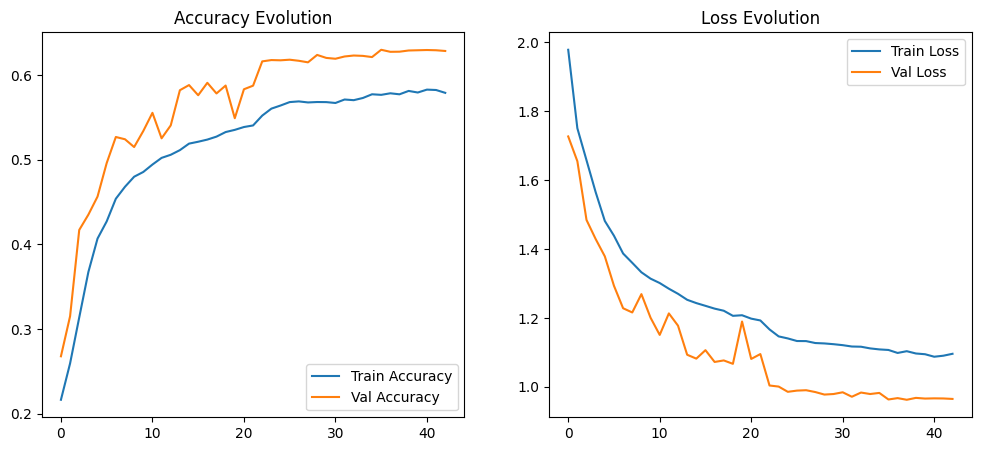

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution')

plt.show()


1/1 [==============================] - 0s 14ms/step


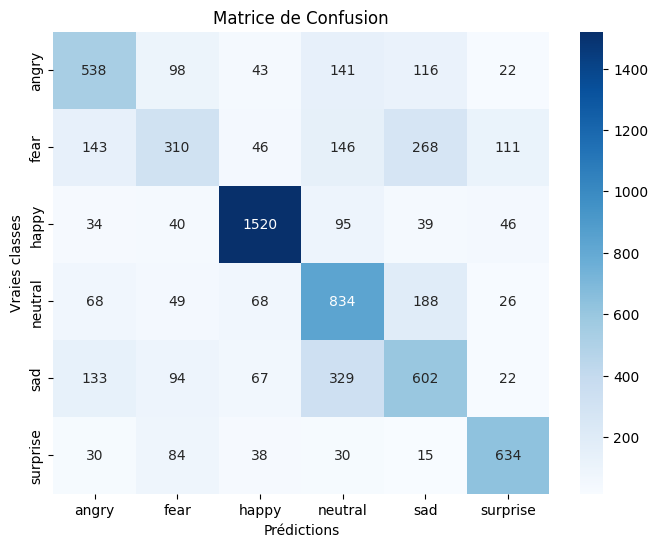

Classification Report:
              precision    recall  f1-score   support

       angry       0.57      0.56      0.57       958
        fear       0.46      0.30      0.36      1024
       happy       0.85      0.86      0.85      1774
     neutral       0.53      0.68      0.59      1233
         sad       0.49      0.48      0.49      1247
    surprise       0.74      0.76      0.75       831

    accuracy                           0.63      7067
   macro avg       0.61      0.61      0.60      7067
weighted avg       0.62      0.63      0.62      7067



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

y_true = []
y_pred = []

for batch in test_generator:
    X_batch, y_batch = batch
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(X_batch), axis=1))

    if len(y_true) >= test_generator.samples:
        break

class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [1]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


In [2]:

def predict_emotion(model, img_path, class_names):
    # Charger l'image en niveaux de gris avec PIL (comme ImageDataGenerator)
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img)  # forme (48, 48, 1)
    
    # Normaliser (comme dans le flow_from_directory)
    img_array = img_array / 255.0
    
    # Ajouter la dimension batch
    img_input = np.expand_dims(img_array, axis=0)  # forme (1, 48, 48, 1)
    
    # Prédiction
    prediction = model.predict(img_input)
    predicted_class = np.argmax(prediction)
    emotion = class_names[predicted_class]
    
    # Afficher l'image avec son résultat
    plt.imshow(img, cmap='gray')
    plt.title(f"Prédiction : {emotion}")
    plt.axis("off")
    plt.show()
    
    return emotion

# Liste des classes (assure-toi qu'elles correspondent à celles utilisées dans ton générateur)
class_names = list(train_generator.class_indices.keys())

# Tester avec une image
img_path = "../validation/surpr1.jpg"
predict_emotion(model, img_path, class_names)


NameError: name 'train_generator' is not defined